In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score,accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

# load model

In [4]:
# 4. Initialize classification model
classification_model = TFAutoModelForSequenceClassification.from_pretrained(
    "pysentimiento/robertuito-base-uncased",
    num_labels=4,
    output_attentions=True,
    ignore_mismatched_sizes=True  # Required for architecture change
)

tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/HateMedia/Modelos/OdioNoOdio/Final/hate-trained-robertuito_OdioNoOdio_final_new_cardiff_extra_layer_tokenizer")
tokenizer.model_max_length = 128

classification_model.get_layer('roberta').trainable = True
classification_model.get_layer('classifier').trainable = True

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
# Re-define the model architecture
num_labels = 4

# set input ids as input
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')

# set attention mask as input
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# modify the model
output = classification_model(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels)(output[:, :])

# set the model to its final form
classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)


In [6]:
# Rebuild the model architecture first
classification_model.load_weights("/content/drive/MyDrive/HateMedia/Modelos/OdioNoOdio/Final/hate-trained-robertuito_OdioNoOdio_final_new_cardiff_extra_layer.h5",skip_mismatch=True, by_name=True)

In [7]:
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1087902   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    76         'attention_mask[0][0]']      
 SequenceClassification)     4),                                                              

# Read data

In [8]:
# Preprocess data function to create TensorFlow datasets
def preprocess_data(split_df,num_labels):
# Tokenize the texts and set maximum length, truncation and padding size
  texts = split_df['text'].tolist()
  encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=128,return_token_type_ids=False)

# Convert the labels to one-hot encoding
  labels = split_df['label'].tolist()
  labels_encoded = tf.one_hot(labels, num_labels)

# Create TensorFlow datasets
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels_encoded))

  return dataset

In [ ]:
# load data
df_in = pd.read_csv('/content/drive/MyDrive/HateMedia/Data/Procesada/Intensidades/df_intensidades.csv')
# drop na values
df_in = df_in.dropna(subset=['text'])
df_in = df_in.dropna(subset=['label'])
# reset index
df_in = df_in.reset_index(drop=True)

# set labels 0=Incívicos,1=Malintencionado,2=Insulto,3=Amenaza
df_in['label'] = df_in['label'] -1
df_in['label'] = df_in['label'].astype(int)
df_in

,text,label
0,@usuario la policía adoctrinada bajo los gobie...,1
1,@usuario porque ustedes deben ser corderos muy...,1
2,El sistema inmunológico ha sido aplastado con ...,1
3,En este caso muerto el perro sigue la rabia,1
4,olvidas tu nacionalidad que eres un panfleto g...,1
...,...,...
352944,avanza hacia el abismo,0
352945,pero eso no es populismo claropopulismo es qui...,1
352946,Como en 33.,0
352947,avanza al abismo,0


In [10]:
# see class distribution
df_in['label'].value_counts()

,count
label,
1,109248
0,105321
3,99250
2,39130


In [11]:
# Split your DataFrame
train_df, temp_df = train_test_split(df_in, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# convert to tensorflow, tokenize and create datasets in trainable format
num_labels = len(df_in['label'].unique())
train_dataset = preprocess_data(train_df,num_labels)
test_dataset = preprocess_data(test_df,num_labels)
val_dataset = preprocess_data(val_df,num_labels)


In [ ]:
# Compute class weights based on the number of samples of each class.
# class weights will be given by n_samples / (n_classes * np.bincount(y))

class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(train_df['label']), y=train_df['label'])
class_weight = np.round(class_weight,2).tolist()
class_weight = {i: class_weight[i] for i in range(len(class_weight))}
class_weight

{0: 0.84, 1: 0.81, 2: 2.25, 3: 0.89}

# Train

In [13]:
# create a warmup schedule
class WarmupLinearSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, max_lr=2e-5):
        super().__init__()
        # cast warmup_steps and max_lr to float to tensorflow format
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.max_lr = max_lr

    def __call__(self, step):
        # cast step to tensorflow format
        step = tf.cast(step, tf.float32)
        # Linear warmup
        lr = self.max_lr * (step / self.warmup_steps)
        # After warmup, keep constant LR
        return tf.minimum(lr, self.max_lr)

In [14]:
# Calculate training parameters
batch_size = 128
epochs = 5
steps_per_epoch = len(train_df) // batch_size
total_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup
print("total_steps:",total_steps,"- warmup_steps:",warmup_steps)

total_steps: 11025 - warmup_steps: 1102


In [15]:
# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=WarmupLinearSchedule(
        warmup_steps=warmup_steps,
        max_lr=2e-5))

# Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    restore_best_weights=True,
    patience=2,
    verbose=1)

In [ ]:
# Compile model
classification_model.compile(
    optimizer=optimizer,  # Pass the optimizer instance directly
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.Recall(name='recall', class_id=2), # Focus on 2
             tf.keras.metrics.Precision(name='precision', class_id=3), # Focus on 3
             tf.keras.metrics.Accuracy(name='accuracy'),
             tf.keras.metrics.F1Score(name="f1_score", average='weighted'), # Use weighted average for f1_score
             tf.keras.metrics.AUC(name='AUC', curve='PR'),
             tf.keras.metrics.RecallAtPrecision(precision=0.6, name='recall_at_precision', class_id=3), # Focus on 3
             tf.keras.metrics.PrecisionAtRecall(recall=0.6, class_id=2)]) # Focus on 2



# Train model
history = classification_model.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    batch_size=batch_size,
    class_weight=class_weight,
    callbacks=callback,
    epochs=epochs)

Epoch 1/5
2206/2206 [==============================] - 776s 332ms/step - loss: 1.0612 - recall: 0.6281 - precision: 0.3842 - accuracy: 0.0000e+00 - f1_score: 0.5106 - AUC: 0.4089 - recall_at_precision: 0.0000e+00 - precision_at_recall: 0.2208 - val_loss: 1.3698 - val_recall: 0.0000e+00 - val_precision: 1.0000 - val_accuracy: 0.0000e+00 - val_f1_score: 0.1380 - val_AUC: 0.2750 - val_recall_at_precision: 1.0174e-04 - val_precision_at_recall: 0.0000e+00
Epoch 2/5
2206/2206 [==============================] - 727s 330ms/step - loss: 1.3770 - recall: 0.1883 - precision: 0.3590 - accuracy: 0.0000e+00 - f1_score: 0.2512 - AUC: 0.2664 - recall_at_precision: 0.0000e+00 - precision_at_recall: 0.1296 - val_loss: 1.3583 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_f1_score: 0.1380 - val_AUC: 0.2832 - val_recall_at_precision: 4.0696e-04 - val_precision_at_recall: 0.0000e+00
Epoch 3/5
2206/2206 [==============================] - 727s 329ms/step - loss: 1.3715 

In [17]:
# Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    restore_best_weights=True,
    patience=2,
    verbose=1)

In [ ]:
# Compile model
classification_model.compile(
    optimizer=optimizer,  # Pass the optimizer instance directly
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.Recall(name='recall', class_id=2), # Focus on 2
             tf.keras.metrics.Precision(name='precision', class_id=3), # Focus on 3
             tf.keras.metrics.Accuracy(name='accuracy'),
             tf.keras.metrics.F1Score(name="f1_score", average='weighted'), # Use weighted average for f1_score
             tf.keras.metrics.AUC(name='AUC', curve='PR'),
             tf.keras.metrics.RecallAtPrecision(precision=0.9, name='recall_at_precision', class_id=3), # Focus on 3
             tf.keras.metrics.PrecisionAtRecall(recall=0.9, class_id=2)]) # Focus on 2



# Train model
history = classification_model.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    batch_size=batch_size,
    class_weight=class_weight,
    callbacks=callback,
    epochs=epochs)

Epoch 1/5
2206/2206 [==============================] - 748s 331ms/step - loss: 0.8525 - recall: 0.8775 - precision: 0.3656 - accuracy: 0.0000e+00 - f1_score: 0.6520 - AUC: 0.4732 - recall_at_precision: 0.0000e+00 - precision_at_recall_1: 0.2496 - val_loss: 0.8256 - val_recall: 0.8671 - val_precision: 0.3453 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6691 - val_AUC: 0.4972 - val_recall_at_precision: 0.0000e+00 - val_precision_at_recall_1: 0.2656
Epoch 2/5
2206/2206 [==============================] - 728s 330ms/step - loss: 0.7711 - recall: 0.9010 - precision: 0.3603 - accuracy: 0.0000e+00 - f1_score: 0.6857 - AUC: 0.4941 - recall_at_precision: 0.0000e+00 - precision_at_recall_1: 0.2894 - val_loss: 0.7944 - val_recall: 0.8550 - val_precision: 0.3458 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6730 - val_AUC: 0.4920 - val_recall_at_precision: 0.0000e+00 - val_precision_at_recall_1: 0.0000e+00
Epoch 3/5
2206/2206 [==============================] - 728s 330ms/step - loss: 0.7034 - recall

# Results

In [46]:
# make predictions
predictions = classification_model.predict(test_dataset.batch(batch_size))

276/276 [==============================] - 30s 110ms/step


In [83]:
# Get true labels from test_df
y_true = test_df['label']

# Get predictions from your model
y_pred = tf.argmax(predictions, axis=1)  # predictions contains probabilities/logits

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[8480,  294,  494, 1296],
       [ 347, 7357, 1494, 1615],
       [ 175,  671, 2805,  244],
       [1929, 2188,  661, 5245]])

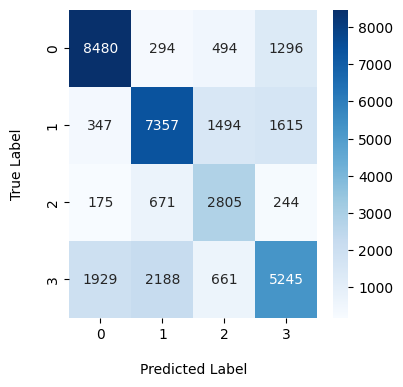

In [84]:
# plot confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("\nPredicted Label")
plt.ylabel("True Label\n")
plt.show()

In [49]:
# Get true labels from test_ds and convert to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_labels)

# For other metrics, get predicted class labels
y_pred = tf.argmax(predictions, axis=1)  # predictions contains probabilities/logits

# Calculate metrics
metrics = {
    "Recall (Macro)": recall_score(y_true, y_pred, average='macro'),
    "Precision (Macro)": precision_score(y_true, y_pred, average='macro'),
    "F1 (Macro)": f1_score(y_true, y_pred, average='macro'),
    "AUC (OvR)": roc_auc_score(y_true_one_hot, predictions, multi_class='ovr'),  # Use one-hot encoded y_true and y_score
    "Accuracy": accuracy_score(y_true, y_pred)
}

# For per-class metrics
per_class_metrics = {
    "Recall (Per Class)": recall_score(y_true, y_pred, average=None),
    "Precision (Per Class)": precision_score(y_true, y_pred, average=None),
    "F1 (Per Class)": f1_score(y_true, y_pred, average=None)
}

# Print results
print("Aggregate Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nPer-Class Metrics:")
for i, (rec, prec, f1) in enumerate(zip(per_class_metrics["Recall (Per Class)"],
                                      per_class_metrics["Precision (Per Class)"],
                                      per_class_metrics["F1 (Per Class)"])):
    print(f"Class {i}: Recall={rec:.4f}, Precision={prec:.4f}, F1={f1:.4f}")

print(classification_report(y_true, y_pred))

Aggregate Metrics:
Recall (Macro): 0.6816
Precision (Macro): 0.6536
F1 (Macro): 0.6621
AUC (OvR): 0.8400
Accuracy: 0.6768

Per-Class Metrics:
Class 0: Recall=0.8027, Precision=0.7758, F1=0.7890
Class 1: Recall=0.6804, Precision=0.7000, F1=0.6901
Class 2: Recall=0.7202, Precision=0.5143, F1=0.6001
Class 3: Recall=0.5233, Precision=0.6244, F1=0.5694
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     10564
           1       0.70      0.68      0.69     10813
           2       0.51      0.72      0.60      3895
           3       0.62      0.52      0.57     10023

    accuracy                           0.68     35295
   macro avg       0.65      0.68      0.66     35295
weighted avg       0.68      0.68      0.68     35295



In [ ]:
history.history

{'loss': [0.6880964636802673, 0.6134354472160339, 1.0438705682754517],
 'recall': [0.9306592345237732, 0.9501563310623169, 0.41582104563713074],
 'precision': [0.4289064407348633, 0.43449872732162476, 0.4329632818698883],
 'accuracy': [0.0, 0.0, 0.0],
 'f1_score': [0.7050412893295288, 0.7364709377288818, 0.46913883090019226],
 'AUC': [0.5174041986465454, 0.5269464254379272, 0.41966715455055237],
 'recall_at_precision': [0.0, 0.0, 0.0],
 'precision_at_recall_9': [0.3011830747127533, 0.3277442157268524, 0.0],
 'val_loss': [0.7198023200035095, 0.7263728976249695, 1.375443458557129],
 'val_recall': [0.8940210342407227, 0.8922247886657715, 0.0],
 'val_precision': [0.4093421697616577, 0.4048369526863098, 0.0],
 'val_accuracy': [0.0, 0.0, 0.0],
 'val_f1_score': [0.7011986970901489, 0.7016660571098328, 0.12131873518228531],
 'val_AUC': [0.5028730034828186, 0.4955997169017792, 0.2860652804374695],
 'val_recall_at_precision': [0.0, 0.0, 0.0],
 'val_precision_at_recall_9': [0.27335047721862793, 0

# Save the model

In [85]:
# Print the model summary
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1087902   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    76         'attention_mask[0][0]']      
 SequenceClassification)     4),                                                              

In [ ]:
# save model history (models metrics while training) to csv file
history_df = pd.DataFrame(history.history)
history_df.to_csv('***.csv')

In [ ]:
# save model weights
classification_model.save_weights("***/Intensidades-trained-robertuito_base_odio_bin.h5")

# save tokenizer
tokenizer.save_pretrained("***/Intensidades-trained-robertuito_base_odio_bin_tokenizer")

('/content/drive/MyDrive/HateMedia/Modelos/Intensidades/Intensidades-trained-robertuito_base_odio_bin_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/HateMedia/Modelos/Intensidades/Intensidades-trained-robertuito_base_odio_bin_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/HateMedia/Modelos/Intensidades/Intensidades-trained-robertuito_base_odio_bin_tokenizer/tokenizer.json')

# requirements

In [88]:
# save requirements as a txt file
!pip freeze > requirements.txt